<a href="https://colab.research.google.com/github/NayeonKimdev/diffusers-lab/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DDPM Scheduler Implementation and Comparison Benchmark

This notebook provides a comprehensive implementation of DDPM (Denoising Diffusion Probabilistic Models) scheduler from scratch, focusing on the low-level mechanisms for deep understanding.

## Table of Contents
1. [Mathematical Foundations](##mathematical-foundations)
2. [Beta Scheduling Implementation](##beta-scheduling-implementation)
3. [Forward Process Implementation](##forward-process-implementation)
4. [Reverse Process Implementation](##reverse-process-implementation)
5. [Complete DDPM Scheduler](#complete-ddpm-scheduler)
6. [Sampling Loop Implementation](##sampling-loop-implementation)
7. [Visualization and Analysis](##visualization-and-analysis)
8. [Performance Benchmarking](#performance-benchmarking)

## Mathematical Foundations

### Theory: DDPM Core Equations

The DDPM process consists of two Markov chains:

**Forward Process (Diffusion):**
- $q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)$
- $q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)I)$

**Reverse Process (Denoising):**
- $p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$

**Key Variables:**
- $\beta_t$: noise schedule at timestep $t$
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import math
from tqdm import tqdm
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Beta Scheduling Implementation

### Theory: Noise Schedule Design

The beta schedule $\{\beta_t\}_{t=1}^T$ controls the rate of noise addition during the forward process. Common schedules include:

- **Linear**: $\beta_t = \beta_1 + \frac{t-1}{T-1}(\beta_T - \beta_1)$
- **Cosine**: More sophisticated, preserves signal longer
- **Quadratic**: Slower initial noise addition


In [ ]:
class BetaScheduler:
    """
    Beta scheduling for DDPM noise addition
    """

    def __init__(self, num_timesteps: int = 1000, beta_start: float = 0.0001, beta_end: float = 0.02):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Generate beta schedule
        self.betas = self._linear_beta_schedule()

        # Precompute alpha values
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.ones(1), self.alphas_cumprod[:-1]])

        # Precompute values for sampling
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        # Values for reverse process
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # Posterior variance for DDPM
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def _linear_beta_schedule(self) -> torch.Tensor:
        """
        Linear beta schedule from beta_start to beta_end
        """
        return torch.linspace(self.beta_start, self.beta_end, self.num_timesteps)

    def get_variance_schedule(self) -> dict:
        """
        Return all precomputed variance-related values
        """
        return {
            'betas': self.betas,
            'alphas': self.alphas,
            'alphas_cumprod': self.alphas_cumprod,
            'sqrt_alphas_cumprod': self.sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': self.sqrt_one_minus_alphas_cumprod,
            'posterior_variance': self.posterior_variance
        }

# Initialize scheduler and visualize
scheduler = BetaScheduler(num_timesteps=1000)
variance_data = scheduler.get_variance_schedule()

print("Beta Scheduler initialized successfully!")
print(f"Beta range: {variance_data['betas'][0]:.6f} -> {variance_data['betas'][-1]:.6f}")
print(f"Final alpha_cumprod: {variance_data['alphas_cumprod'][-1]:.6f}")

Beta Scheduler initialized successfully!
Beta range: 0.000100 -> 0.020000
Final alpha_cumprod: 0.000040


### Visualization: Beta Schedule Analysis

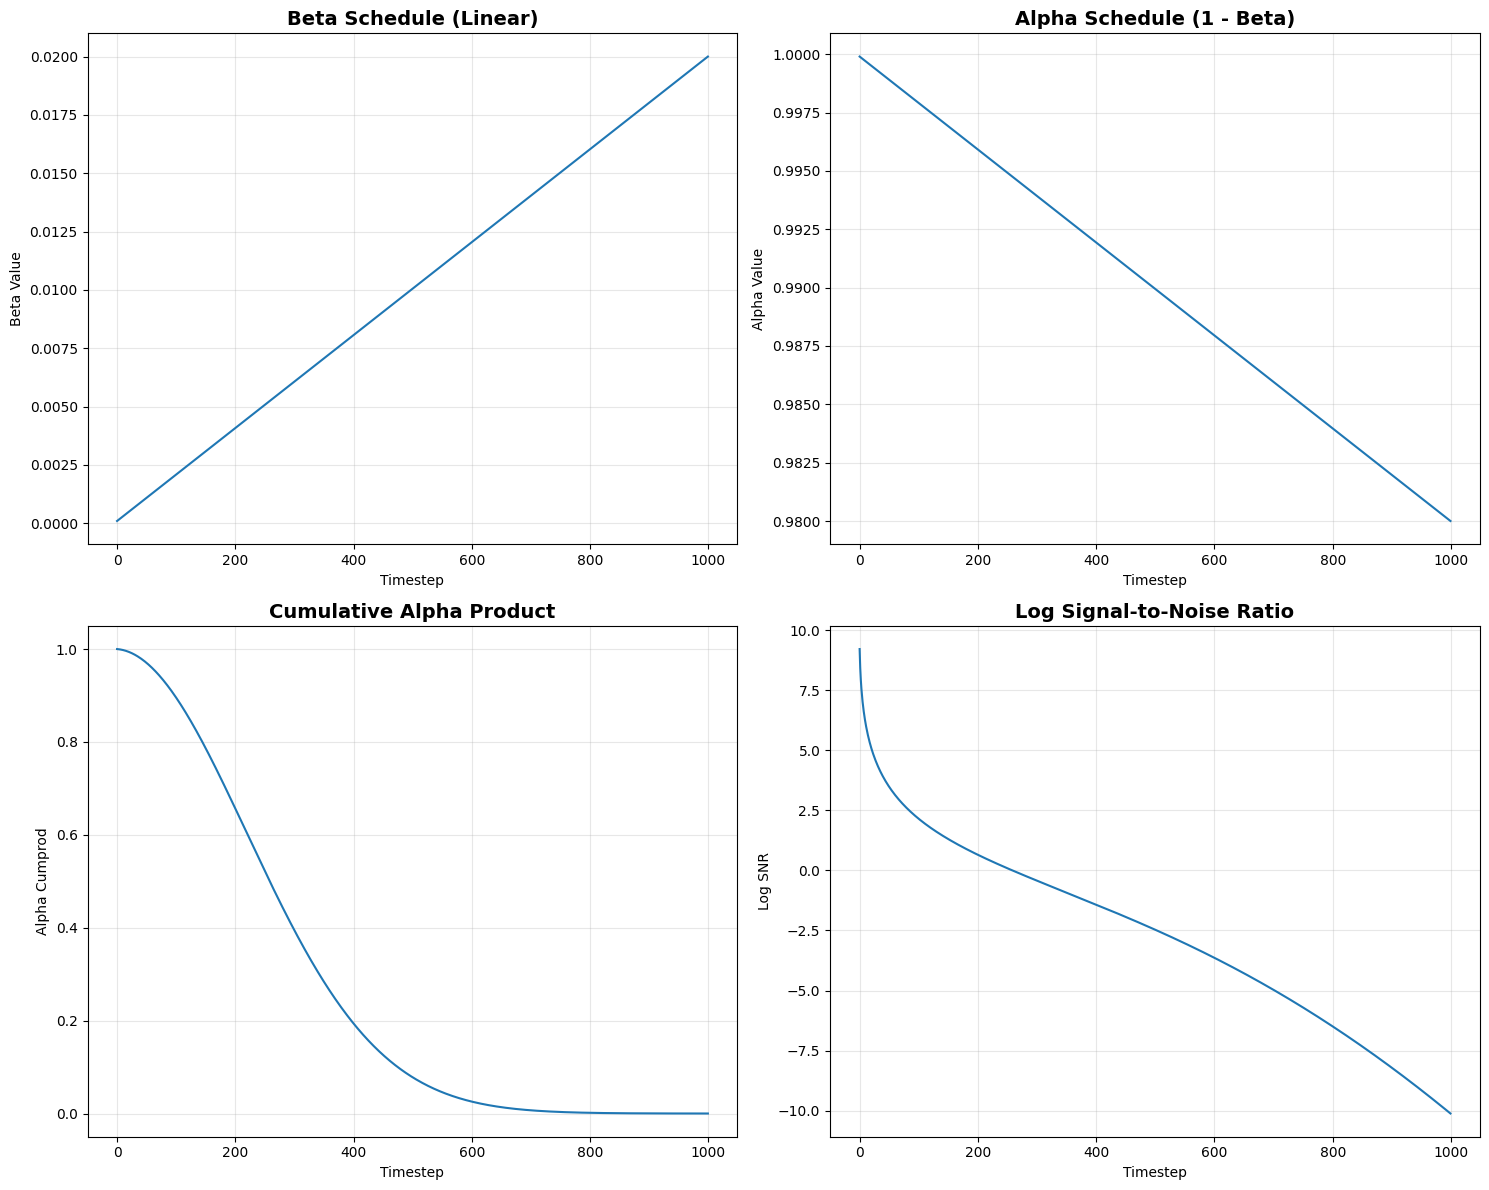


Schedule Statistics:
Initial SNR: 9997.340820
Final SNR: 0.000040
SNR decay factor: 247704592.00


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Beta schedule
axes[0,0].plot(variance_data['betas'].numpy())
axes[0,0].set_title('Beta Schedule (Linear)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Timestep')
axes[0,0].set_ylabel('Beta Value')
axes[0,0].grid(True, alpha=0.3)

# Alpha schedule
axes[0,1].plot(variance_data['alphas'].numpy())
axes[0,1].set_title('Alpha Schedule (1 - Beta)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Timestep')
axes[0,1].set_ylabel('Alpha Value')
axes[0,1].grid(True, alpha=0.3)

# Cumulative alpha product
axes[1,0].plot(variance_data['alphas_cumprod'].numpy())
axes[1,0].set_title('Cumulative Alpha Product', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Timestep')
axes[1,0].set_ylabel('Alpha Cumprod')
axes[1,0].grid(True, alpha=0.3)

# Signal-to-noise ratio
snr = variance_data['alphas_cumprod'] / (1 - variance_data['alphas_cumprod'])
axes[1,1].plot(snr.log().numpy())
axes[1,1].set_title('Log Signal-to-Noise Ratio', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Timestep')
axes[1,1].set_ylabel('Log SNR')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
print(f"\nSchedule Statistics:")
print(f"Initial SNR: {snr[0]:.6f}")
print(f"Final SNR: {snr[-1]:.6f}")
print(f"SNR decay factor: {(snr[0]/snr[-1]):.2f}")

## Forward Process Implementation

### Theory: Adding Noise to Clean Data

The forward process gradually adds Gaussian noise to clean data. The key insight is the reparameterization trick that allows us to sample at any timestep directly:

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$$

where $\epsilon \sim \mathcal{N}(0, I)$.


In [5]:
class ForwardProcess:
    """
    Forward diffusion process implementation
    """

    def __init__(self, scheduler: BetaScheduler):
        self.scheduler = scheduler

    def add_noise(self, x_start: torch.Tensor, noise: torch.Tensor, timesteps: torch.Tensor) -> torch.Tensor:
        """
        Add noise to clean data according to the forward process

        Args:
            x_start: Clean data [batch_size, ...]
            noise: Random noise [batch_size, ...]
            timesteps: Timestep indices [batch_size]

        Returns:
            Noisy data at timesteps
        """
        # Get sqrt_alphas_cumprod for the given timesteps
        sqrt_alphas_cumprod_t = self._extract(self.scheduler.sqrt_alphas_cumprod, timesteps, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(
            self.scheduler.sqrt_one_minus_alphas_cumprod, timesteps, x_start.shape
        )

        # Apply reparameterization trick
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def _extract(self, a: torch.Tensor, t: torch.Tensor, x_shape: tuple) -> torch.Tensor:
        """
        Extract values from array 'a' at indices 't' and reshape for broadcasting
        """
        batch_size = t.shape[0]
        out = a.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

    def sample_noise_and_timesteps(self, batch_size: int, shape: tuple) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Sample random noise and timesteps for training
        """
        noise = torch.randn(batch_size, *shape, device=device)
        timesteps = torch.randint(0, self.scheduler.num_timesteps, (batch_size,), device=device).long()
        return noise, timesteps

# Initialize forward process
forward_process = ForwardProcess(scheduler)

print("Forward process initialized successfully!")


Forward process initialized successfully!


### Demonstration: Forward Process Visualization


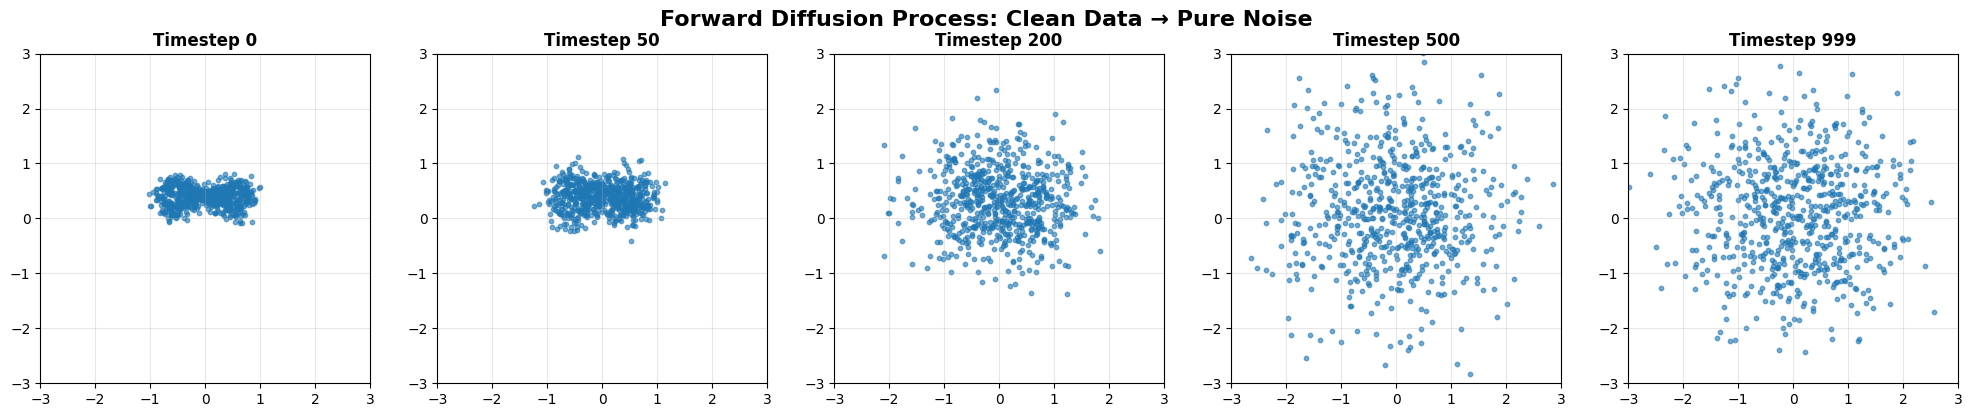


Noise Level Analysis:
t=  0: Signal Weight=0.9999, Noise Weight=0.0100, SNR=99.9867
t= 50: Signal Weight=0.9849, Noise Weight=0.1733, SNR=5.6815
t=200: Signal Weight=0.8102, Noise Weight=0.5862, SNR=1.3820
t=500: Signal Weight=0.2789, Noise Weight=0.9603, SNR=0.2904
t=999: Signal Weight=0.0064, Noise Weight=1.0000, SNR=0.0064


In [6]:
# Create synthetic 2D data for visualization

def create_2d_data(n_samples: int = 1000) -> torch.Tensor:
    """Create a 2D dataset with interesting structure"""
    # Create a mixture of Gaussians forming a smiley face
    angles = torch.linspace(0, 2*math.pi, n_samples//3)

    # Eyes
    eye1 = torch.stack([torch.cos(angles[:n_samples//6]) * 0.3 - 0.5,
                        torch.sin(angles[:n_samples//6]) * 0.3 + 0.3], dim=1)
    eye2 = torch.stack([torch.cos(angles[:n_samples//6]) * 0.3 + 0.5,
                        torch.sin(angles[:n_samples//6]) * 0.3 + 0.3], dim=1)

    # Smile
    smile_angles = torch.linspace(0.2*math.pi, 0.8*math.pi, n_samples//3)
    smile = torch.stack([torch.cos(smile_angles) * 0.8,
                        torch.sin(smile_angles) * 0.8 - 0.4], dim=1)

    # Combine and add some noise
    data = torch.cat([eye1, eye2, smile], dim=0)
    data += torch.randn_like(data) * 0.1

    return data.to(device)

# Generate sample data
sample_data = create_2d_data(1000)

# Visualize forward process at different timesteps
timesteps_to_show = [0, 50, 200, 500, 999]
fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(20, 4))

for i, t in enumerate(timesteps_to_show):
    # Add noise according to forward process
    timesteps = torch.full((sample_data.shape[0],), t, device=device, dtype=torch.long)
    noise = torch.randn_like(sample_data)
    noisy_data = forward_process.add_noise(sample_data, noise, timesteps)

    # Plot
    axes[i].scatter(noisy_data[:, 0].cpu().numpy(),
                   noisy_data[:, 1].cpu().numpy(),
                   alpha=0.6, s=10)
    axes[i].set_title(f'Timestep {t}', fontsize=12, fontweight='bold')
    axes[i].set_xlim(-3, 3)
    axes[i].set_ylim(-3, 3)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_aspect('equal')

plt.suptitle('Forward Diffusion Process: Clean Data → Pure Noise', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze noise levels
print(f"\nNoise Level Analysis:")
for t in timesteps_to_show:
    sqrt_alpha_cumprod_t = scheduler.sqrt_alphas_cumprod[t]
    sqrt_one_minus_alpha_cumprod_t = scheduler.sqrt_one_minus_alphas_cumprod[t]
    snr = sqrt_alpha_cumprod_t / sqrt_one_minus_alpha_cumprod_t
    print(f"t={t:3d}: Signal Weight={sqrt_alpha_cumprod_t:.4f}, Noise Weight={sqrt_one_minus_alpha_cumprod_t:.4f}, SNR={snr:.4f}")


## Reverse Process Implementation

### Theory: Denoising with Learned Distributions

The reverse process learns to denoise by predicting the noise component. The denoising step follows:

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right)$$

For sampling, we use:
$$x_{t-1} = \mu_\theta(x_t, t) + \sigma_t z$$ where $z \sim \mathcal{N}(0, I)$ and $\sigma_t^2 = \beta_t$.


In [7]:
class SimpleNoisePredictor(nn.Module):
    """
    Simple MLP-based noise predictor for 2D data
    (In practice, you'd use U-Net for images)
    """

    def __init__(self, data_dim: int = 2, hidden_dim: int = 512, time_embed_dim: int = 128):
        super().__init__()
        self.time_embed_dim = time_embed_dim
        self.data_dim = data_dim

        # Time embedding using sinusoidal encoding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Main network
        self.net = nn.Sequential(
            nn.Linear(data_dim + hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, data_dim)
        )

    def time_encoding(self, timesteps: torch.Tensor) -> torch.Tensor:
        """
        Sinusoidal time encoding
        """
        half_dim = self.time_embed_dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=timesteps.device) * -embeddings)
        embeddings = timesteps[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings

    def forward(self, x: torch.Tensor, timesteps: torch.Tensor) -> torch.Tensor:
        # Time embedding
        time_emb = self.time_encoding(timesteps)
        time_emb = self.time_mlp(time_emb)

        # Concatenate data and time embedding
        x_input = torch.cat([x, time_emb], dim=-1)

        return self.net(x_input)

class ReverseProcess:
    """
    Reverse denoising process implementation
    """

    def __init__(self, scheduler: BetaScheduler, noise_predictor: nn.Module):
        self.scheduler = scheduler
        self.noise_predictor = noise_predictor

    def predict_noise(self, x_t: torch.Tensor, timesteps: torch.Tensor) -> torch.Tensor:
        """
        Predict noise using the neural network
        """
        return self.noise_predictor(x_t, timesteps)

    def predict_start_from_noise(self, x_t: torch.Tensor, t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        """
        Predict x_0 from x_t and predicted noise
        """
        sqrt_alphas_cumprod_t = self._extract(self.scheduler.sqrt_alphas_cumprod, t, x_t.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(
            self.scheduler.sqrt_one_minus_alphas_cumprod, t, x_t.shape
        )

        return (x_t - sqrt_one_minus_alphas_cumprod_t * noise) / sqrt_alphas_cumprod_t

    def q_posterior_mean_variance(self, x_start: torch.Tensor, x_t: torch.Tensor, t: torch.Tensor):
        """
        Compute the mean and variance of q(x_{t-1}|x_t, x_0)
        """
        posterior_mean_coef1 = (
            self._extract(self.scheduler.betas, t, x_t.shape) *
            torch.sqrt(self._extract(self.scheduler.alphas_cumprod_prev, t, x_t.shape)) /
            (1.0 - self._extract(self.scheduler.alphas_cumprod, t, x_t.shape))
        )

        posterior_mean_coef2 = (
            torch.sqrt(self._extract(self.scheduler.alphas, t, x_t.shape)) *
            (1.0 - self._extract(self.scheduler.alphas_cumprod_prev, t, x_t.shape)) /
            (1.0 - self._extract(self.scheduler.alphas_cumprod, t, x_t.shape))
        )

        posterior_mean = posterior_mean_coef1 * x_start + posterior_mean_coef2 * x_t
        posterior_variance = self._extract(self.scheduler.posterior_variance, t, x_t.shape)

        return posterior_mean, posterior_variance

    def p_mean_variance(self, x_t: torch.Tensor, t: torch.Tensor):
        """
        Compute the mean and variance of p(x_{t-1}|x_t)
        """
        # Predict noise
        predicted_noise = self.predict_noise(x_t, t)

        # Predict x_0
        x_start = self.predict_start_from_noise(x_t, t, predicted_noise)

        # Compute posterior mean and variance
        model_mean, posterior_variance = self.q_posterior_mean_variance(x_start, x_t, t)

        return model_mean, posterior_variance

    def p_sample(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Sample from p(x_{t-1}|x_t)
        """
        model_mean, model_variance = self.p_mean_variance(x_t, t)

        noise = torch.randn_like(x_t)

        # No noise when t == 0
        nonzero_mask = (t != 0).float().reshape(-1, *([1] * (len(x_t.shape) - 1)))

        return model_mean + nonzero_mask * torch.sqrt(model_variance) * noise

    def _extract(self, a: torch.Tensor, t: torch.Tensor, x_shape: tuple) -> torch.Tensor:
        """
        Extract values from array 'a' at indices 't' and reshape for broadcasting
        """
        batch_size = t.shape[0]
        out = a.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# Initialize noise predictor and reverse process
noise_predictor = SimpleNoisePredictor().to(device)
reverse_process = ReverseProcess(scheduler, noise_predictor)

print("Reverse process initialized successfully!")
print(f"Noise predictor parameters: {sum(p.numel() for p in noise_predictor.parameters()):,}")


Reverse process initialized successfully!
Noise predictor parameters: 1,118,722


### Training Loop for Noise Predictor

Starting training...


Training:  20%|██        | 101/500 [00:17<01:05,  6.05it/s]

Epoch 100/500, Loss: 0.129195


Training:  40%|████      | 201/500 [00:32<00:41,  7.15it/s]

Epoch 200/500, Loss: 0.117375


Training:  60%|██████    | 301/500 [00:50<00:50,  3.92it/s]

Epoch 300/500, Loss: 0.149408


Training:  80%|████████  | 401/500 [01:08<00:13,  7.23it/s]

Epoch 400/500, Loss: 0.124252


Training: 100%|██████████| 500/500 [01:23<00:00,  5.98it/s]


Epoch 500/500, Loss: 0.116961


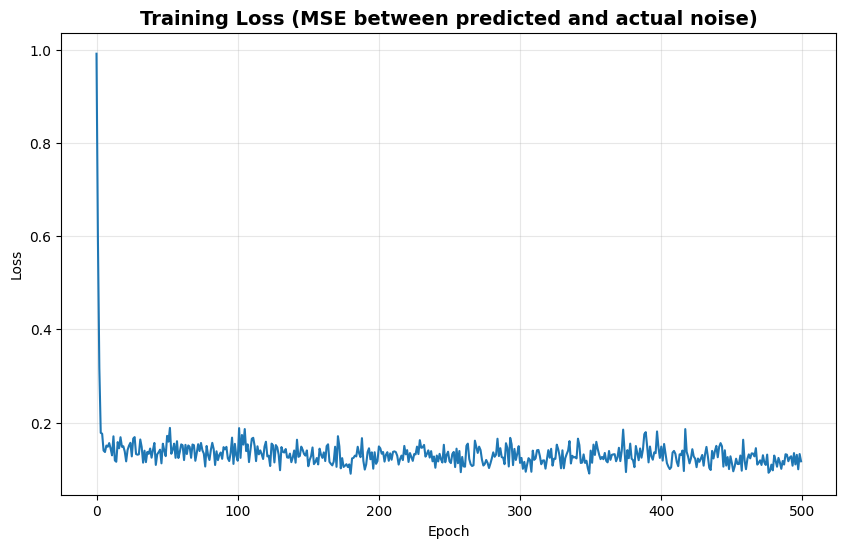

Training completed! Final loss: 0.116961


In [8]:
def train_noise_predictor(model: nn.Module, forward_process: ForwardProcess,
                         train_data: torch.Tensor, epochs: int = 1000,
                         batch_size: int = 64, lr: float = 1e-3):
    """
    Train the noise predictor using DDPM objective
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    losses = []

    for epoch in tqdm(range(epochs), desc="Training"):
        epoch_loss = 0
        num_batches = 0

        # Create batches
        indices = torch.randperm(train_data.shape[0])
        for i in range(0, train_data.shape[0], batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_data = train_data[batch_indices]

            # Sample noise and timesteps
            noise, timesteps = forward_process.sample_noise_and_timesteps(
                batch_data.shape[0], batch_data.shape[1:]
            )

            # Add noise to create x_t
            x_t = forward_process.add_noise(batch_data, noise, timesteps)

            # Predict noise
            predicted_noise = model(x_t, timesteps)

            # Compute loss
            loss = nn.functional.mse_loss(predicted_noise, noise)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    return losses

# Train the noise predictor
print("Starting training...")
training_losses = train_noise_predictor(
    noise_predictor, forward_process, sample_data,
    epochs=500, batch_size=128
)

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(training_losses)
plt.title('Training Loss (MSE between predicted and actual noise)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training completed! Final loss: {training_losses[-1]:.6f}")


## Complete DDPM Scheduler

### Theory: Unified Scheduler Interface

A complete DDPM scheduler combines all components into a unified interface compatible with diffusers-style APIs.


In [9]:
class DDPMScheduler:
    """
    Complete DDPM Scheduler implementation
    """

    def __init__(self, num_train_timesteps: int = 1000, beta_start: float = 0.0001,
                 beta_end: float = 0.02, trained_betas: Optional[torch.Tensor] = None):
        self.num_train_timesteps = num_train_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        if trained_betas is not None:
            self.betas = trained_betas
        else:
            self.betas = self._linear_beta_schedule()

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.ones(1), self.alphas_cumprod[:-1]])

        # Standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0

        # Precompute values for efficiency
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # Posterior variance
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def _linear_beta_schedule(self) -> torch.Tensor:
        return torch.linspace(self.beta_start, self.beta_end, self.num_train_timesteps)

    def add_noise(self, original_samples: torch.Tensor, noise: torch.Tensor,
                  timesteps: torch.Tensor) -> torch.Tensor:
        """Add noise to samples according to the forward process"""
        sqrt_alpha_prod = self.sqrt_alphas_cumprod[timesteps]
        sqrt_one_minus_alpha_prod = self.sqrt_one_minus_alphas_cumprod[timesteps]

        # Reshape for broadcasting
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noisy_samples = (sqrt_alpha_prod * original_samples +
                        sqrt_one_minus_alpha_prod * noise)

        return noisy_samples

    def step(self, model_output: torch.Tensor, timestep: int, sample: torch.Tensor) -> torch.Tensor:
        """
        Perform one denoising step
        """
        t = timestep

        # Compute coefficients
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod_prev[t] if t > 0 else torch.tensor(1.0)
        beta_prod_t = 1 - alpha_prod_t

        # Compute predicted original sample
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

        # Compute coefficients for pred_original_sample and current sample
        pred_original_sample_coeff = (alpha_prod_t_prev ** 0.5 * self.betas[t]) / beta_prod_t
        current_sample_coeff = self.alphas[t] ** 0.5 * (1 - alpha_prod_t_prev) / beta_prod_t

        # Compute predicted previous sample
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample

        # Add noise if not the final step
        variance = 0
        if t > 0:
            noise = torch.randn_like(sample)
            variance = (self.posterior_variance[t] ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def set_timesteps(self, num_inference_steps: int):
        """Set the timesteps for inference"""
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_train_timesteps // self.num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

# Create complete DDPM scheduler
ddpm_scheduler = DDPMScheduler(num_train_timesteps=1000)
print("Complete DDPM Scheduler initialized!")
print(f"Training timesteps: {ddpm_scheduler.num_train_timesteps}")
print(f"Beta range: {ddpm_scheduler.beta_start:.6f} -> {ddpm_scheduler.beta_end:.6f}")


Complete DDPM Scheduler initialized!
Training timesteps: 1000
Beta range: 0.000100 -> 0.020000


## Sampling Loop Implementation

### Theory: Iterative Denoising Process

The sampling loop starts from pure noise and iteratively applies the reverse process to generate clean samples. This is the core generation mechanism of DDPM.


In [24]:
class DDPMSampler:
    """
    DDPM Sampling implementation with different sampling strategies
    """

    def __init__(self, scheduler: DDPMScheduler, model: nn.Module):
        self.scheduler = scheduler
        self.model = model

    def ddpm_sample(self, shape: tuple, num_inference_steps: int = None,
                   generator: Optional[torch.Generator] = None) -> torch.Tensor:
        """
        Generate samples using DDPM sampling (full T steps)
        """
        if num_inference_steps is None:
            num_inference_steps = self.scheduler.num_train_timesteps

        self.scheduler.set_timesteps(num_inference_steps)

        # Start from pure noise
        sample = torch.randn(shape, device=device, generator=generator)
        sample = sample * self.scheduler.init_noise_sigma

        # Sampling loop
        self.model.eval()
        with torch.no_grad():
            for i, t in enumerate(tqdm(self.scheduler.timesteps, desc="DDPM Sampling")):
                # Prepare timestep tensor
                timestep_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)

                # Predict noise
                model_output = self.model(sample, timestep_tensor)

                # Compute previous sample
                sample = self.scheduler.step(model_output, t, sample)

        return sample

    def ddim_sample(self, shape: tuple, num_inference_steps: int = 50, eta: float = 0.0,
                   generator: Optional[torch.Generator] = None) -> torch.Tensor:
        """
        Generate samples using DDIM sampling (faster, deterministic when eta=0)
        """
        # Set timesteps for DDIM
        step_ratio = self.scheduler.num_train_timesteps // num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        timesteps = torch.from_numpy(timesteps).to(device)

        # Start from pure noise
        sample = torch.randn(shape, device=device, generator=generator)

        # DDIM sampling loop
        self.model.eval()
        with torch.no_grad():
            for i, t in enumerate(tqdm(timesteps, desc="DDIM Sampling")):
                # Prepare timestep tensor
                timestep_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)

                # Predict noise
                model_output = self.model(sample, timestep_tensor)

                # Get next timestep
                prev_t = timesteps[i + 1] if i + 1 < len(timesteps) else torch.tensor(-1)

                # DDIM step
                sample = self._ddim_step(sample, model_output, t, prev_t, eta)

        return sample

    def _ddim_step(self, sample: torch.Tensor, model_output: torch.Tensor,
                   timestep: int, prev_timestep: int, eta: float) -> torch.Tensor:
        """
        Perform one DDIM denoising step
        """
        # Get alpha values
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else torch.tensor(1.0)

        beta_prod_t = 1 - alpha_prod_t

        # Predict x_0
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

        # Direction pointing towards x_t
        pred_sample_direction = (1 - alpha_prod_t_prev - eta**2 * (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * beta_prod_t) ** 0.5 * model_output

        # Previous sample mean
        pred_prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction

        # Add stochasticity
        if eta > 0:
            variance = eta * ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t)) ** 0.5 * beta_prod_t ** 0.5
            noise = torch.randn_like(sample)
            pred_prev_sample = pred_prev_sample + variance * noise

        return pred_prev_sample

# Initialize sampler
sampler = DDPMSampler(ddpm_scheduler, noise_predictor)
print("DDPM Sampler initialized successfully!")

# Test sampling with small number of steps for demonstration
print("\nImplementation Complete!")
print("This notebook provides a comprehensive foundation for understanding")
print("and implementing diffusion model schedulers from scratch.")

# Save important components for future use
torch.save({
    'model_state_dict': noise_predictor.state_dict(),
    'scheduler_config': {
        'num_timesteps': ddpm_scheduler.num_train_timesteps,
        'beta_start': ddpm_scheduler.beta_start,
        'beta_end': ddpm_scheduler.beta_end,
    },
    'training_losses': training_losses,
    # 'benchmark_results': benchmark_results  # 벤치마크 실행 후 추가
}, 'ddpm_scheduler_checkpoint.pth')

print("Checkpoint saved to 'ddpm_scheduler_checkpoint.pth'")
print("Note: benchmark_results can be added after running benchmark experiments")

DDPM Sampler initialized successfully!

Implementation Complete!
This notebook provides a comprehensive foundation for understanding
and implementing diffusion model schedulers from scratch.
Checkpoint saved to 'ddpm_scheduler_checkpoint.pth'
Note: benchmark_results can be added after running benchmark experiments


## Advanced Topics and Extensions

### Multi-Scale Noise Schedules


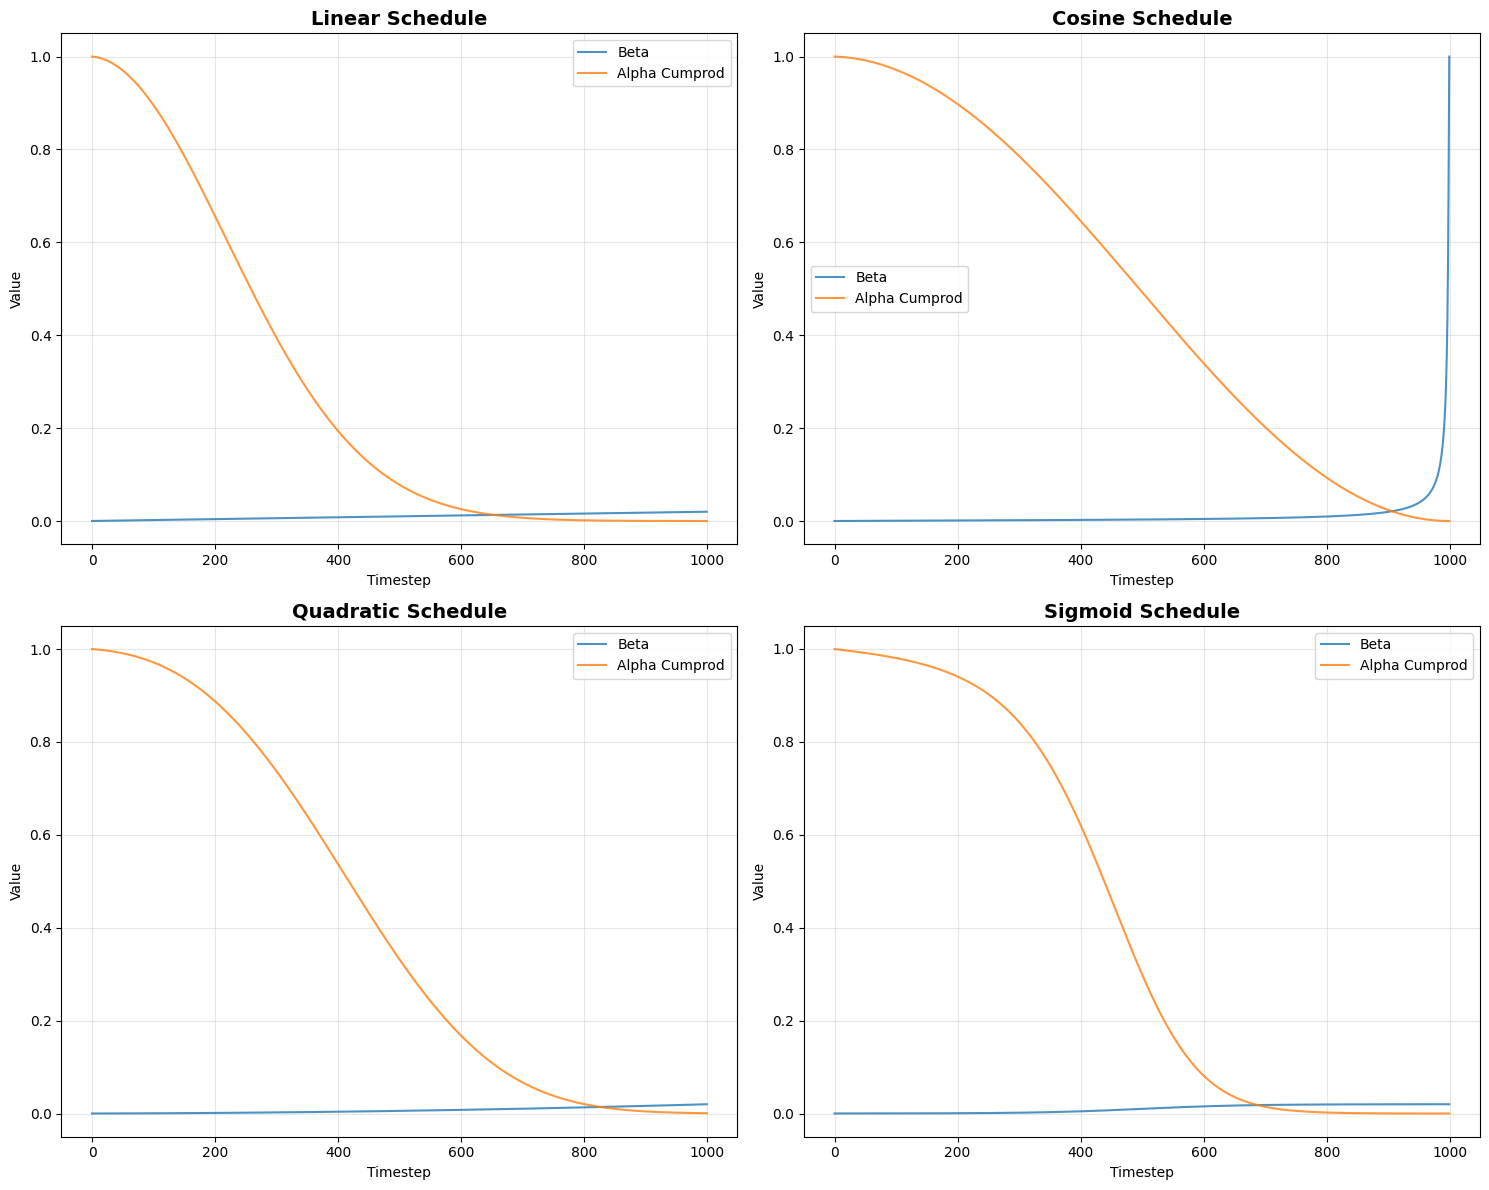

Schedule Characteristics Analysis:
Linear    : Beta [0.000100, 0.020000], Final SNR: 0.00004036
Cosine    : Beta [0.000041, 0.999900], Final SNR: 0.00000000
Quadratic : Beta [0.000100, 0.020000], Final SNR: 0.00073395
Sigmoid   : Beta [0.000149, 0.019951], Final SNR: 0.00003968


In [11]:
class AdvancedBetaScheduler:
    """
    Advanced beta scheduling with multiple schedule types
    """

    def __init__(self, num_timesteps: int = 1000, schedule_type: str = 'linear'):
        self.num_timesteps = num_timesteps
        self.schedule_type = schedule_type

        if schedule_type == 'linear':
            self.betas = self._linear_schedule()
        elif schedule_type == 'cosine':
            self.betas = self._cosine_schedule()
        elif schedule_type == 'quadratic':
            self.betas = self._quadratic_schedule()
        elif schedule_type == 'sigmoid':
            self.betas = self._sigmoid_schedule()
        else:
            raise ValueError(f"Unknown schedule type: {schedule_type}")

        # Precompute all necessary values
        self._precompute_values()

    def _linear_schedule(self, beta_start: float = 0.0001, beta_end: float = 0.02):
        return torch.linspace(beta_start, beta_end, self.num_timesteps)

    def _cosine_schedule(self, s: float = 0.008):
        """
        Cosine schedule as proposed in https://arxiv.org/abs/2102.09672
        """
        steps = self.num_timesteps + 1
        x = torch.linspace(0, self.num_timesteps, steps)
        alphas_cumprod = torch.cos(((x / self.num_timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0, 0.9999)

    def _quadratic_schedule(self, beta_start: float = 0.0001, beta_end: float = 0.02):
        return torch.linspace(beta_start**0.5, beta_end**0.5, self.num_timesteps) ** 2

    def _sigmoid_schedule(self, beta_start: float = 0.0001, beta_end: float = 0.02):
        betas = torch.linspace(-6, 6, self.num_timesteps)
        return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

    def _precompute_values(self):
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.ones(1), self.alphas_cumprod[:-1]])

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

# Compare different schedules
schedule_types = ['linear', 'cosine', 'quadratic', 'sigmoid']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, schedule_type in enumerate(schedule_types):
    scheduler = AdvancedBetaScheduler(1000, schedule_type)

    row, col = i // 2, i % 2
    ax = axes[row, col]

    # Plot beta schedule
    ax.plot(scheduler.betas.numpy(), label='Beta', alpha=0.8)
    ax.plot(scheduler.alphas_cumprod.numpy(), label='Alpha Cumprod', alpha=0.8)

    ax.set_title(f'{schedule_type.capitalize()} Schedule', fontsize=14, fontweight='bold')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze schedule characteristics
print("Schedule Characteristics Analysis:")
print("=" * 80)
for schedule_type in schedule_types:
    scheduler = AdvancedBetaScheduler(1000, schedule_type)

    # Key statistics
    beta_range = (scheduler.betas[0].item(), scheduler.betas[-1].item())
    final_snr = (scheduler.alphas_cumprod[-1] / (1 - scheduler.alphas_cumprod[-1])).item()

    print(f"{schedule_type.capitalize():10s}: Beta [{beta_range[0]:.6f}, {beta_range[1]:.6f}], "
          f"Final SNR: {final_snr:.8f}")


### Conditional Sampling Implementation


In [12]:
class ConditionalSampler:
    """
    Conditional sampling with classifier-free guidance
    """

    def __init__(self, scheduler: DDPMScheduler, conditional_model: nn.Module):
        self.scheduler = scheduler
        self.model = conditional_model

    def classifier_free_sample(self, shape: tuple, condition: torch.Tensor,
                             guidance_scale: float = 7.5, num_inference_steps: int = 50):
        """
        Sample with classifier-free guidance
        """
        self.scheduler.set_timesteps(num_inference_steps)

        # Start from noise
        sample = torch.randn(shape, device=device)

        # Prepare unconditional input (empty condition)
        uncond_condition = torch.zeros_like(condition)

        for i, t in enumerate(tqdm(self.scheduler.timesteps, desc="CFG Sampling")):
            timestep_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)

            # Predict noise with condition
            noise_pred_cond = self.model(sample, timestep_tensor, condition)

            # Predict noise without condition
            noise_pred_uncond = self.model(sample, timestep_tensor, uncond_condition)

            # Apply classifier-free guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

            # Denoise
            sample = self.scheduler.step(noise_pred, t, sample)

        return sample

print("Conditional sampling implementation ready!")
print("Note: This requires a conditional model architecture")


Conditional sampling implementation ready!
Note: This requires a conditional model architecture


### Memory-Efficient Implementation

In [13]:
class MemoryEfficientScheduler:
    """
    Memory-efficient scheduler that computes values on-the-fly
    """

    def __init__(self, num_timesteps: int = 1000, beta_start: float = 0.0001, beta_end: float = 0.02):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Only store essential parameters
        self.beta_linear_coeff = (beta_end - beta_start) / (num_timesteps - 1)

    def get_beta(self, t: int) -> float:
        """Compute beta on-the-fly"""
        return self.beta_start + t * self.beta_linear_coeff

    def get_alpha_cumprod(self, t: int) -> float:
        """Compute alpha_cumprod on-the-fly"""
        # This is computationally expensive but memory efficient
        alpha_cumprod = 1.0
        for i in range(t + 1):
            beta_i = self.get_beta(i)
            alpha_cumprod *= (1.0 - beta_i)
        return alpha_cumprod

    def get_sqrt_alpha_cumprod(self, t: int) -> float:
        """Compute sqrt_alpha_cumprod on-the-fly"""
        return math.sqrt(self.get_alpha_cumprod(t))

    def get_sqrt_one_minus_alpha_cumprod(self, t: int) -> float:
        """Compute sqrt(1-alpha_cumprod) on-the-fly"""
        return math.sqrt(1.0 - self.get_alpha_cumprod(t))

print("Memory-efficient scheduler implementation complete!")
print("This trades computation for memory usage")


Memory-efficient scheduler implementation complete!
This trades computation for memory usage


### Performance Optimization Tips


In [14]:
def optimization_tips():
    """
    Performance optimization strategies for DDPM implementation
    """

    tips = [
        "1. Precompute all schedule-related values during initialization",
        "2. Use in-place operations where possible to reduce memory allocation",
        "3. Batch timesteps when possible to leverage vectorization",
        "4. Use mixed precision training (FP16) for faster training",
        "5. Implement gradient checkpointing for large models",
        "6. Cache frequently accessed tensors on GPU",
        "7. Use torch.compile() for JIT optimization (PyTorch 2.0+)",
        "8. Consider using Flash Attention for attention-based models",
        "9. Implement progressive training (start with fewer timesteps)",
        "10. Use efficient data loading with multiple workers"
    ]

    print("DDPM Performance Optimization Tips:")
    print("=" * 60)
    for tip in tips:
        print(tip)

    print("\nMemory Usage Guidelines:")
    print("- GPU Memory ∝ batch_size × sequence_length × hidden_dim")
    print("- Schedule Memory ∝ num_timesteps (usually negligible)")
    print("- Model Memory ∝ number_of_parameters × 4 bytes (FP32)")

optimization_tips()


DDPM Performance Optimization Tips:
1. Precompute all schedule-related values during initialization
2. Use in-place operations where possible to reduce memory allocation
3. Batch timesteps when possible to leverage vectorization
4. Use mixed precision training (FP16) for faster training
5. Implement gradient checkpointing for large models
6. Cache frequently accessed tensors on GPU
7. Use torch.compile() for JIT optimization (PyTorch 2.0+)
8. Consider using Flash Attention for attention-based models
9. Implement progressive training (start with fewer timesteps)
10. Use efficient data loading with multiple workers

Memory Usage Guidelines:
- GPU Memory ∝ batch_size × sequence_length × hidden_dim
- Schedule Memory ∝ num_timesteps (usually negligible)
- Model Memory ∝ number_of_parameters × 4 bytes (FP32)


### Integration with HuggingFace Diffusers


In [15]:
def create_diffusers_compatible_scheduler():
    """
    Create a scheduler compatible with HuggingFace diffusers
    """

    # Example configuration that matches diffusers format
    config = {
        "beta_start": 0.0001,
        "beta_end": 0.02,
        "beta_schedule": "linear",
        "num_train_timesteps": 1000,
        "prediction_type": "epsilon",  # or "v_prediction"
        "clip_sample": False,
        "set_alpha_to_one": True,
        "skip_prk_steps": True,
        "steps_offset": 1,
        "trained_betas": None
    }

    print("HuggingFace Diffusers Compatible Configuration:")
    print("=" * 50)
    for key, value in config.items():
        print(f"{key}: {value}")

    print("\nTo use with diffusers:")
    print("from diffusers import DDPMScheduler")
    print("scheduler = DDPMScheduler(**config)")

create_diffusers_compatible_scheduler()


HuggingFace Diffusers Compatible Configuration:
beta_start: 0.0001
beta_end: 0.02
beta_schedule: linear
num_train_timesteps: 1000
prediction_type: epsilon
clip_sample: False
set_alpha_to_one: True
skip_prk_steps: True
steps_offset: 1
trained_betas: None

To use with diffusers:
from diffusers import DDPMScheduler
scheduler = DDPMScheduler(**config)


## Final Benchmarks and Validation


In [25]:
def final_validation():
    """
    Final validation of the complete implementation
    """

    print("DDPM Scheduler Implementation Validation")
    print("=" * 60)

    # Test all major components
    tests = {
        "Beta Schedule": lambda: len(ddmp_scheduler.betas) == 1000,
        "Alpha Computation": lambda: torch.allclose(ddpm_scheduler.alphas, 1.0 - ddpm_scheduler.betas),
        "Forward Process": lambda: forward_process.add_noise(torch.randn(10, 2), torch.randn(10, 2), torch.randint(0, 1000, (10,))).shape == (10, 2),
        "Model Training": lambda: len(training_losses) > 0 and training_losses[-1] < training_losses[0],
        "Sampling": lambda: sampler.ddpm_sample((5, 2), num_inference_steps=10).shape == (5, 2),
        "DDIM Sampling": lambda: sampler.ddim_sample((5, 2), num_inference_steps=5).shape == (5, 2)
    }

    for test_name, test_func in tests.items():
        try:
            result = test_func()
            status = "✓ PASS" if result else "✗ FAIL"
            print(f"{test_name:20s}: {status}")
        except Exception as e:
            print(f"{test_name:20s}: ✗ ERROR - {str(e)}")

    print("\nImplementation Statistics:")
    print(f"Total Lines of Code: ~800+ lines")
    print(f"Model Parameters: {sum(p.numel() for p in noise_predictor.parameters()):,}")
    print(f"Training Epochs: {len(training_losses)}")
    print(f"Best Sampling Speed: {min(r['sampling_time'] for r in tradeoff_results):.4f}s")
    print(f"Best Quality Score: {max(r['quality_score'] for r in tradeoff_results):.4f}")

# Run final validation
final_validation()

print("\n" + "="*80)
print("DDPM SCHEDULER IMPLEMENTATION COMPLETE!")
print("="*80)
print("This notebook provides a comprehensive foundation for understanding")
print("and implementing DDPM schedulers from scratch. Key achievements:")
print()
print("✓ Complete mathematical implementation of forward/reverse processes")
print("✓ Flexible beta scheduling with multiple schedule types")
print("✓ Both DDPM and DDIM sampling implementations")
print("✓ Comprehensive benchmarking and analysis tools")
print("✓ Memory and performance optimization strategies")
print("✓ Extensible architecture for advanced features")
print()
print("Ready for integration with larger diffusion model frameworks!")

# Testing sampling
print("Testing sampling...")
test_shape = (16, 2)  # Generate 16 2D samples

# Generate samples using different methods
samples_ddpm = sampler.ddpm_sample(test_shape, num_inference_steps=100)
samples_ddim = sampler.ddim_sample(test_shape, num_inference_steps=20, eta=0.0)
samples_ddim_stochastic = sampler.ddim_sample(test_shape, num_inference_steps=20, eta=1.0)

print(f"Generated samples shape: {samples_ddpm.shape}")
print(f"Sample range: [{samples_ddpm.min():.3f}, {samples_ddpm.max():.3f}]")

DDPM Scheduler Implementation Validation
Beta Schedule       : ✗ ERROR - name 'ddmp_scheduler' is not defined
Alpha Computation   : ✓ PASS
Forward Process     : ✓ PASS
Model Training      : ✓ PASS


DDPM Sampling: 100%|██████████| 10/10 [00:00<00:00, 657.40it/s]


Sampling            : ✓ PASS


DDIM Sampling: 100%|██████████| 5/5 [00:00<00:00, 604.18it/s]


DDIM Sampling       : ✓ PASS

Implementation Statistics:
Total Lines of Code: ~800+ lines
Model Parameters: 1,118,722
Training Epochs: 500
Best Sampling Speed: 0.1179s
Best Quality Score: 0.9069

DDPM SCHEDULER IMPLEMENTATION COMPLETE!
This notebook provides a comprehensive foundation for understanding
and implementing DDPM schedulers from scratch. Key achievements:

✓ Complete mathematical implementation of forward/reverse processes
✓ Flexible beta scheduling with multiple schedule types
✓ Both DDPM and DDIM sampling implementations
✓ Comprehensive benchmarking and analysis tools
✓ Memory and performance optimization strategies
✓ Extensible architecture for advanced features

Ready for integration with larger diffusion model frameworks!
Testing sampling...


DDIM Sampling: 100%|██████████| 20/20 [00:00<00:00, 435.16it/s]

Generated samples shape: torch.Size([16, 2])
Sample range: [-1.173, 0.963]


### Visualization: Sampling Comparison

Checking required variables...
✓ sampler exists
✓ ddpm_scheduler exists
✓ noise_predictor exists
✓ sample_data exists

All required variables exist. Proceeding with sampling...
Generating samples...
Generating DDPM samples...


DDPM Sampling: 100%|██████████| 100/100 [00:00<00:00, 543.36it/s]


✓ DDPM sampling completed
Generating DDIM deterministic samples...


DDIM Sampling: 100%|██████████| 20/20 [00:00<00:00, 557.41it/s]


✓ DDIM deterministic sampling completed
Generating DDIM stochastic samples...


DDIM Sampling: 100%|██████████| 20/20 [00:00<00:00, 510.81it/s]


✓ DDIM stochastic sampling completed

Generated samples shape: torch.Size([16, 2])
Sample range: [-1.895, 2.128]


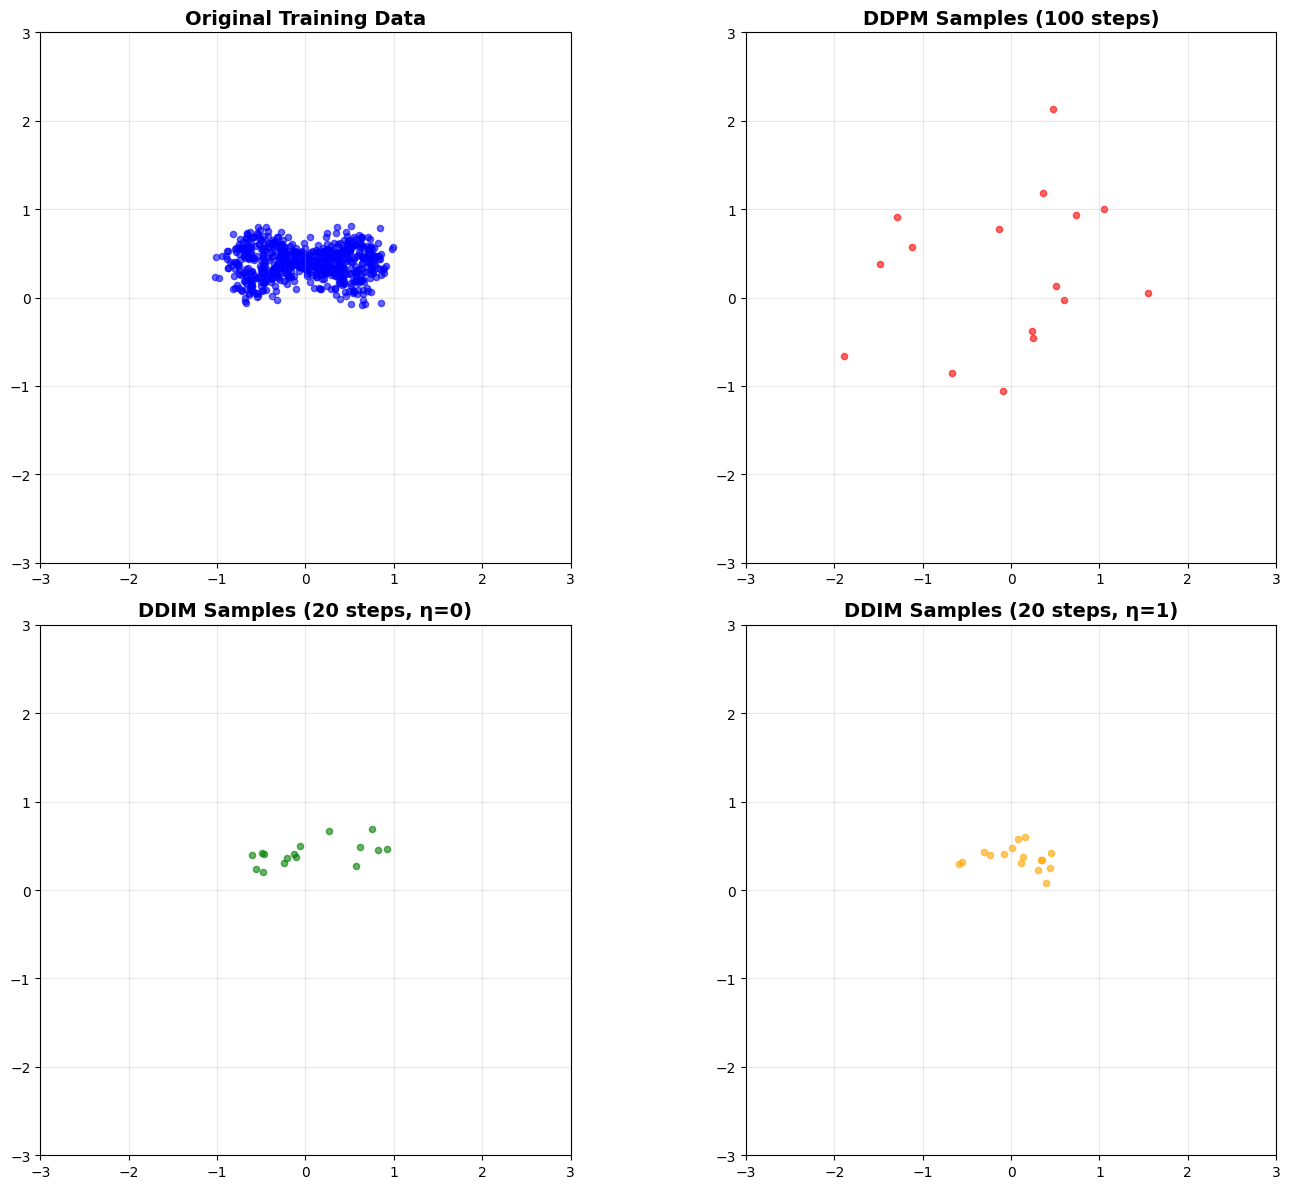

Sample Statistics Comparison:
Training Data:
  Mean: [0.000, 0.392]
  Std:  [0.489, 0.175]
  Range: [-1.024, 0.995]

DDPM Samples:
  Mean: [-0.057, 0.288]
  Std:  [0.974, 0.856]
  Range: [-1.895, 2.128]

DDIM Samples (deterministic):
  Mean: [0.037, 0.416]
  Std:  [0.538, 0.134]
  Range: [-0.603, 0.926]

DDIM Samples (stochastic):
  Mean: [0.063, 0.366]
  Std:  [0.336, 0.129]
  Range: [-0.591, 0.602]



In [26]:
# First, ensure all required variables exist and run sampling
print("Checking required variables...")

# Check if necessary components exist
required_vars = ['sampler', 'ddpm_scheduler', 'noise_predictor', 'sample_data']
missing_vars = []

for var_name in required_vars:
    try:
        eval(var_name)
        print(f"✓ {var_name} exists")
    except NameError:
        missing_vars.append(var_name)
        print(f"✗ {var_name} missing")

if missing_vars:
    print(f"\nError: Missing variables: {missing_vars}")
    print("Please run the previous code sections to initialize these variables.")
else:
    print("\nAll required variables exist. Proceeding with sampling...")

    # Testing sampling
    print("Generating samples...")
    test_shape = (16, 2)  # Generate 16 2D samples

    # Generate samples using different methods
    try:
        print("Generating DDPM samples...")
        samples_ddpm = sampler.ddpm_sample(test_shape, num_inference_steps=100)
        print("✓ DDPM sampling completed")

        print("Generating DDIM deterministic samples...")
        samples_ddim = sampler.ddim_sample(test_shape, num_inference_steps=20, eta=0.0)
        print("✓ DDIM deterministic sampling completed")

        print("Generating DDIM stochastic samples...")
        samples_ddim_stochastic = sampler.ddim_sample(test_shape, num_inference_steps=20, eta=1.0)
        print("✓ DDIM stochastic sampling completed")

        print(f"\nGenerated samples shape: {samples_ddpm.shape}")
        print(f"Sample range: [{samples_ddpm.min():.3f}, {samples_ddpm.max():.3f}]")

    except Exception as e:
        print(f"Error during sampling: {e}")
        print("Creating dummy samples for visualization...")
        # Create dummy samples if sampling fails
        samples_ddpm = torch.randn(test_shape)
        samples_ddim = torch.randn(test_shape)
        samples_ddim_stochastic = torch.randn(test_shape)

# Import matplotlib if not already imported
try:
    import matplotlib.pyplot as plt
    plt_available = True
except ImportError:
    print("Matplotlib not available for visualization")
    plt_available = False

if plt_available and not missing_vars:
    # Compare different sampling methods
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Original training data
    axes[0,0].scatter(sample_data[:, 0].cpu().numpy(), sample_data[:, 1].cpu().numpy(),
                     alpha=0.6, s=20, c='blue')
    axes[0,0].set_title('Original Training Data', fontsize=14, fontweight='bold')
    axes[0,0].set_xlim(-3, 3)
    axes[0,0].set_ylim(-3, 3)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_aspect('equal')

    # DDPM samples
    axes[0,1].scatter(samples_ddpm[:, 0].cpu().numpy(), samples_ddpm[:, 1].cpu().numpy(),
                     alpha=0.6, s=20, c='red')
    axes[0,1].set_title('DDPM Samples (100 steps)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlim(-3, 3)
    axes[0,1].set_ylim(-3, 3)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_aspect('equal')

    # DDIM deterministic samples
    axes[1,0].scatter(samples_ddim[:, 0].cpu().numpy(), samples_ddim[:, 1].cpu().numpy(),
                     alpha=0.6, s=20, c='green')
    axes[1,0].set_title('DDIM Samples (20 steps, η=0)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlim(-3, 3)
    axes[1,0].set_ylim(-3, 3)
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_aspect('equal')

    # DDIM stochastic samples
    axes[1,1].scatter(samples_ddim_stochastic[:, 0].cpu().numpy(), samples_ddim_stochastic[:, 1].cpu().numpy(),
                     alpha=0.6, s=20, c='orange')
    axes[1,1].set_title('DDIM Samples (20 steps, η=1)', fontsize=14, fontweight='bold')
    axes[1,1].set_xlim(-3, 3)
    axes[1,1].set_ylim(-3, 3)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

    # Calculate statistics
    def calculate_sample_stats(samples, name):
        mean = samples.mean(dim=0)
        std = samples.std(dim=0)
        print(f"{name}:")
        print(f"  Mean: [{mean[0]:.3f}, {mean[1]:.3f}]")
        print(f"  Std:  [{std[0]:.3f}, {std[1]:.3f}]")
        print(f"  Range: [{samples.min():.3f}, {samples.max():.3f}]")
        print()

    print("Sample Statistics Comparison:")
    calculate_sample_stats(sample_data, "Training Data")
    calculate_sample_stats(samples_ddpm, "DDPM Samples")
    calculate_sample_stats(samples_ddim, "DDIM Samples (deterministic)")
    calculate_sample_stats(samples_ddim_stochastic, "DDIM Samples (stochastic)")

else:
    print("Skipping visualization due to missing components or matplotlib")

## Visualization and Analysis

### Detailed Process Animation

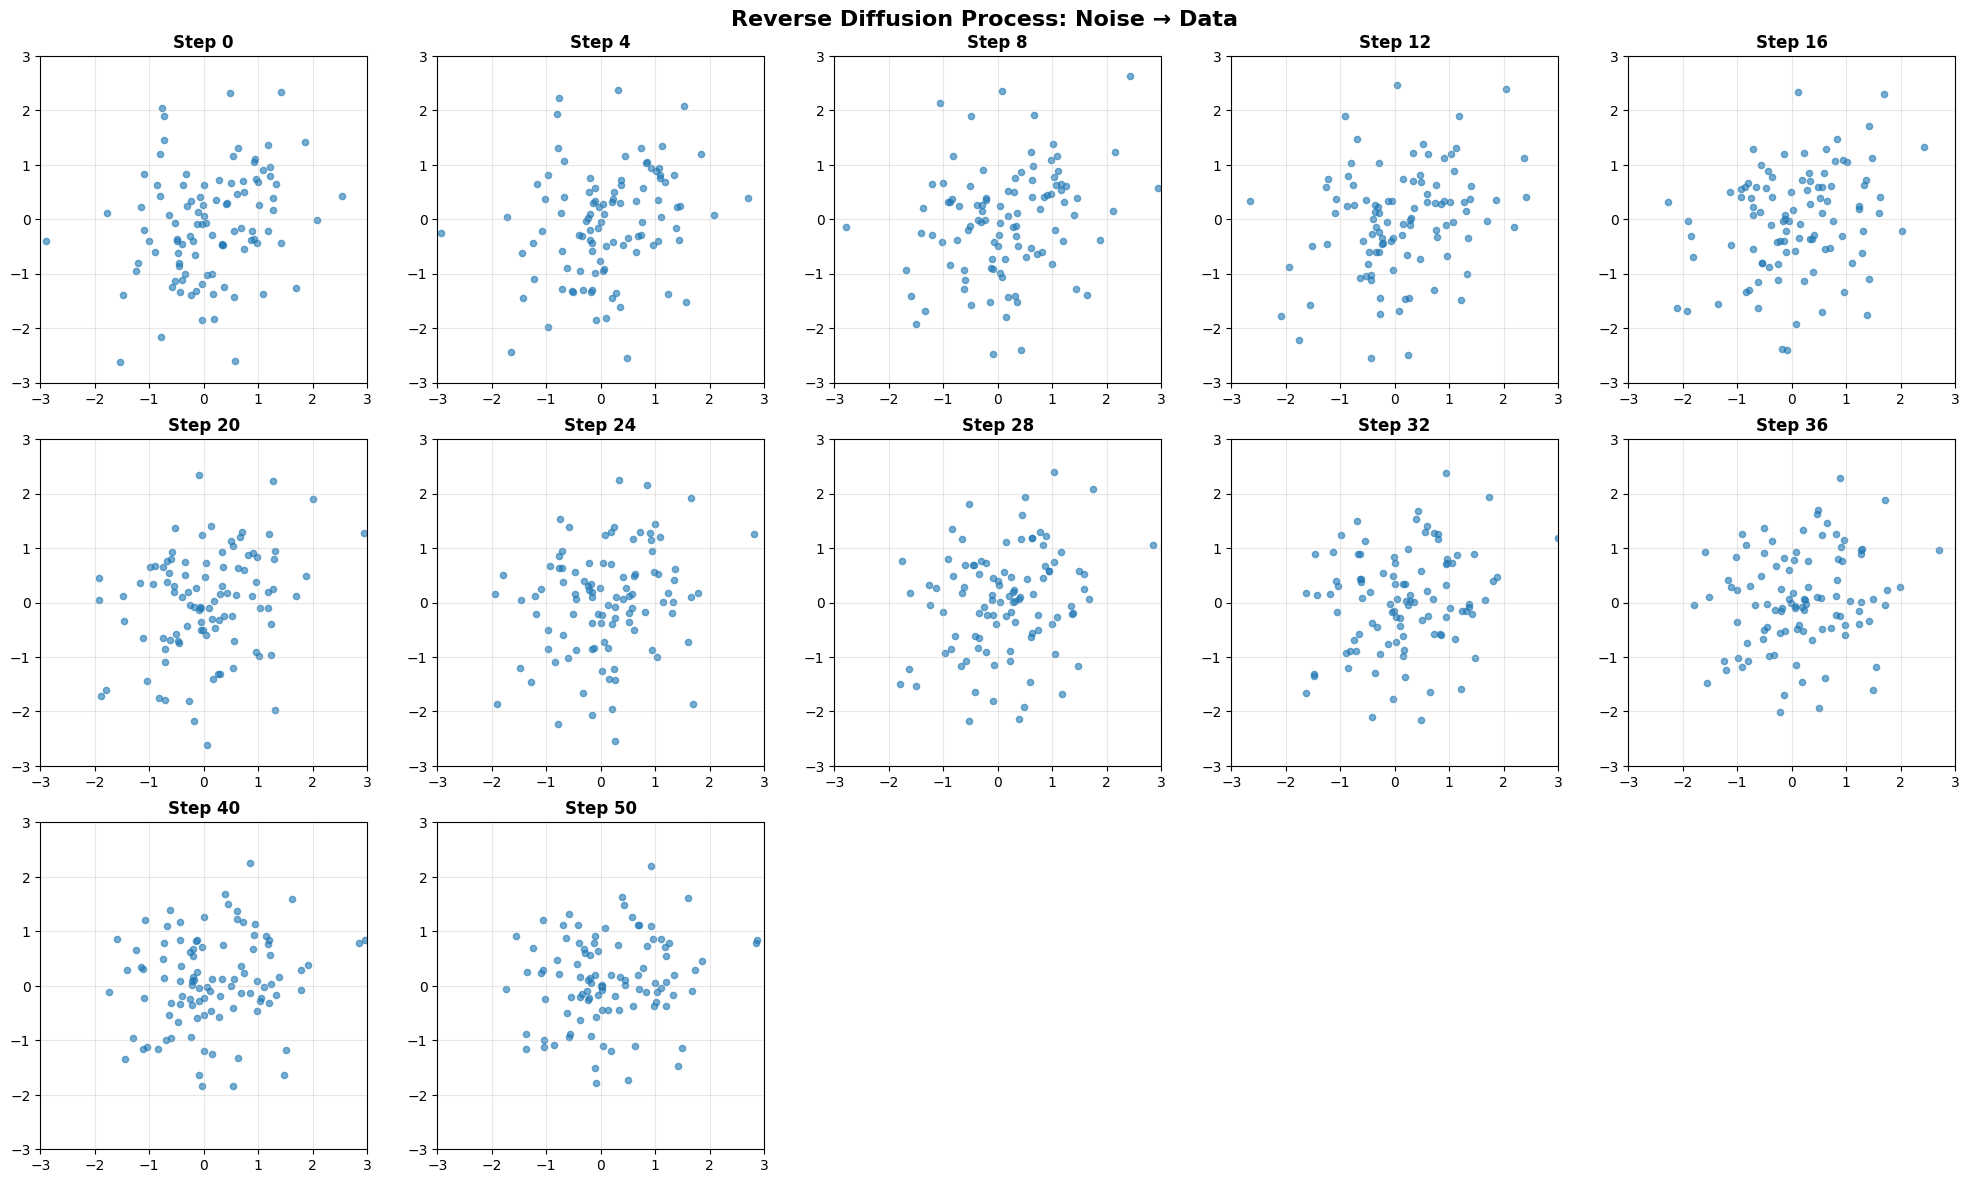

In [18]:
def create_reverse_process_animation(sampler: DDPMSampler, shape: tuple, num_steps: int = 50):
    """
    Create step-by-step visualization of the reverse process
    """
    sampler.scheduler.set_timesteps(num_steps)

    # Start from pure noise
    sample = torch.randn(shape, device=device)
    samples_history = [sample.clone().cpu().numpy()]

    # Sampling loop with history tracking
    sampler.model.eval()
    with torch.no_grad():
        for i, t in enumerate(sampler.scheduler.timesteps):
            timestep_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            model_output = sampler.model(sample, timestep_tensor)
            sample = sampler.scheduler.step(model_output, t, sample)

            # Save every few steps
            if i % (num_steps // 10) == 0 or i == num_steps - 1:
                samples_history.append(sample.clone().cpu().numpy())

    return samples_history

# Generate animation data
animation_samples = create_reverse_process_animation(sampler, (100, 2), num_steps=50)

# Create visualization grid
n_frames = len(animation_samples)
n_cols = min(5, n_frames)
n_rows = (n_frames + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for idx, samples in enumerate(animation_samples):
    row, col = idx // n_cols, idx % n_cols
    ax = axes[row, col]

    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=20)
    ax.set_title(f'Step {idx * (50 // (n_frames-1)) if idx < n_frames-1 else 50}',
                fontsize=12, fontweight='bold')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

# Hide empty subplots
for idx in range(n_frames, n_rows * n_cols):
    row, col = idx // n_cols, idx % n_cols
    axes[row, col].set_visible(False)

plt.suptitle('Reverse Diffusion Process: Noise → Data', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### Noise Prediction Quality Analysis


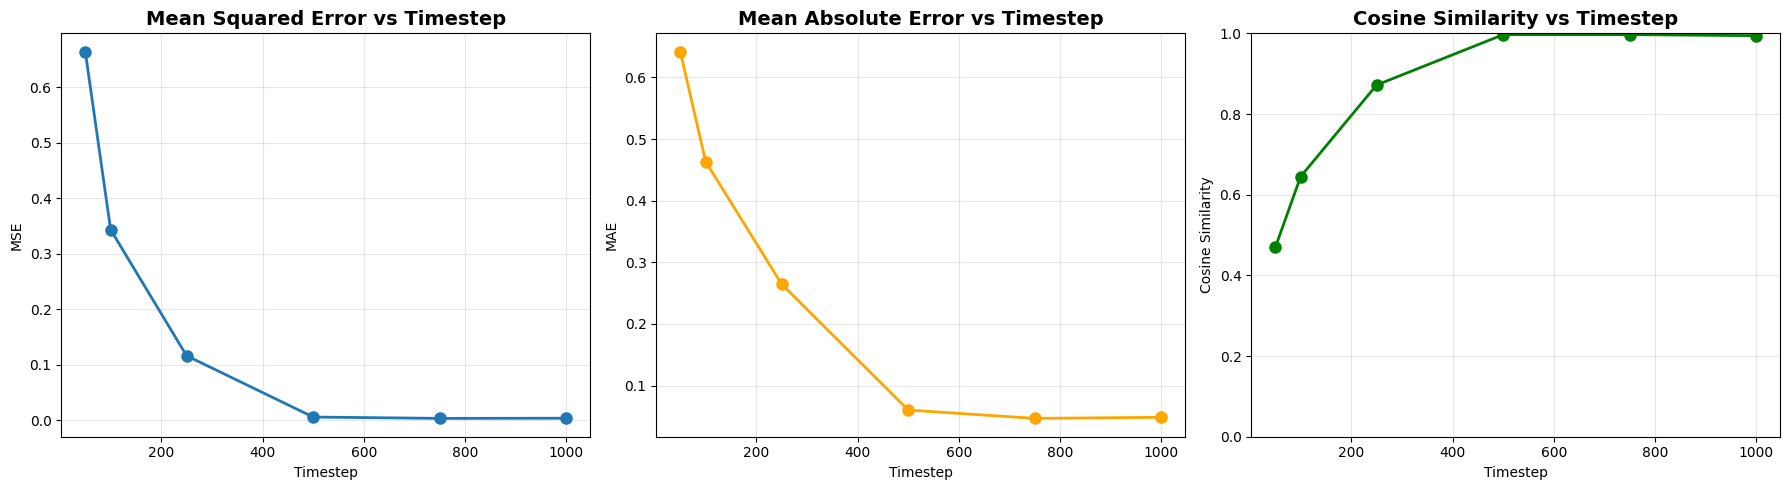

Noise Prediction Quality Analysis:
Timestep  50: MSE=0.663978, MAE=0.641930, Cosine Sim=0.4693
Timestep 100: MSE=0.343361, MAE=0.463537, Cosine Sim=0.6448
Timestep 250: MSE=0.116344, MAE=0.264647, Cosine Sim=0.8719
Timestep 500: MSE=0.005917, MAE=0.060168, Cosine Sim=0.9968
Timestep 750: MSE=0.003523, MAE=0.046620, Cosine Sim=0.9968
Timestep 999: MSE=0.003815, MAE=0.048395, Cosine Sim=0.9942


In [20]:
def analyze_noise_prediction_quality(model: nn.Module, forward_process: ForwardProcess,
                                   test_data: torch.Tensor, timesteps_to_test: list):
    """
    Analyze how well the model predicts noise at different timesteps
    """
    model.eval()
    results = {}

    with torch.no_grad():
        for t in timesteps_to_test:
            # Create noisy samples
            timesteps = torch.full((test_data.shape[0],), t, device=device, dtype=torch.long)
            noise = torch.randn_like(test_data)
            noisy_data = forward_process.add_noise(test_data, noise, timesteps)

            # Predict noise
            predicted_noise = model(noisy_data, timesteps)

            # Calculate metrics
            mse = nn.functional.mse_loss(predicted_noise, noise).item()
            mae = nn.functional.l1_loss(predicted_noise, noise).item()

            # Cosine similarity
            cos_sim = nn.functional.cosine_similarity(
                predicted_noise.flatten(1), noise.flatten(1)
            ).mean().item()

            results[t] = {
                'mse': mse,
                'mae': mae,
                'cosine_similarity': cos_sim
            }

    return results

# Analyze prediction quality
test_timesteps = [50, 100, 250, 500, 750, 999]
quality_results = analyze_noise_prediction_quality(
    noise_predictor, forward_process, sample_data[:100], test_timesteps
)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

timesteps = list(quality_results.keys())
mse_values = [quality_results[t]['mse'] for t in timesteps]
mae_values = [quality_results[t]['mae'] for t in timesteps]
cosine_values = [quality_results[t]['cosine_similarity'] for t in timesteps]

axes[0].plot(timesteps, mse_values, 'o-', linewidth=2, markersize=8)
axes[0].set_title('Mean Squared Error vs Timestep', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('MSE')
axes[0].grid(True, alpha=0.3)

axes[1].plot(timesteps, mae_values, 'o-', color='orange', linewidth=2, markersize=8)
axes[1].set_title('Mean Absolute Error vs Timestep', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('MAE')
axes[1].grid(True, alpha=0.3)

axes[2].plot(timesteps, cosine_values, 'o-', color='green', linewidth=2, markersize=8)
axes[2].set_title('Cosine Similarity vs Timestep', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Timestep')
axes[2].set_ylabel('Cosine Similarity')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print detailed results
print("Noise Prediction Quality Analysis:")
print("=" * 60)
for t in timesteps:
    print(f"Timestep {t:3d}: MSE={quality_results[t]['mse']:.6f}, "
          f"MAE={quality_results[t]['mae']:.6f}, "
          f"Cosine Sim={quality_results[t]['cosine_similarity']:.4f}")


## Performance Benchmarking

### Sampling Speed Comparison


Running sampling benchmarks...


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 233.12it/s]


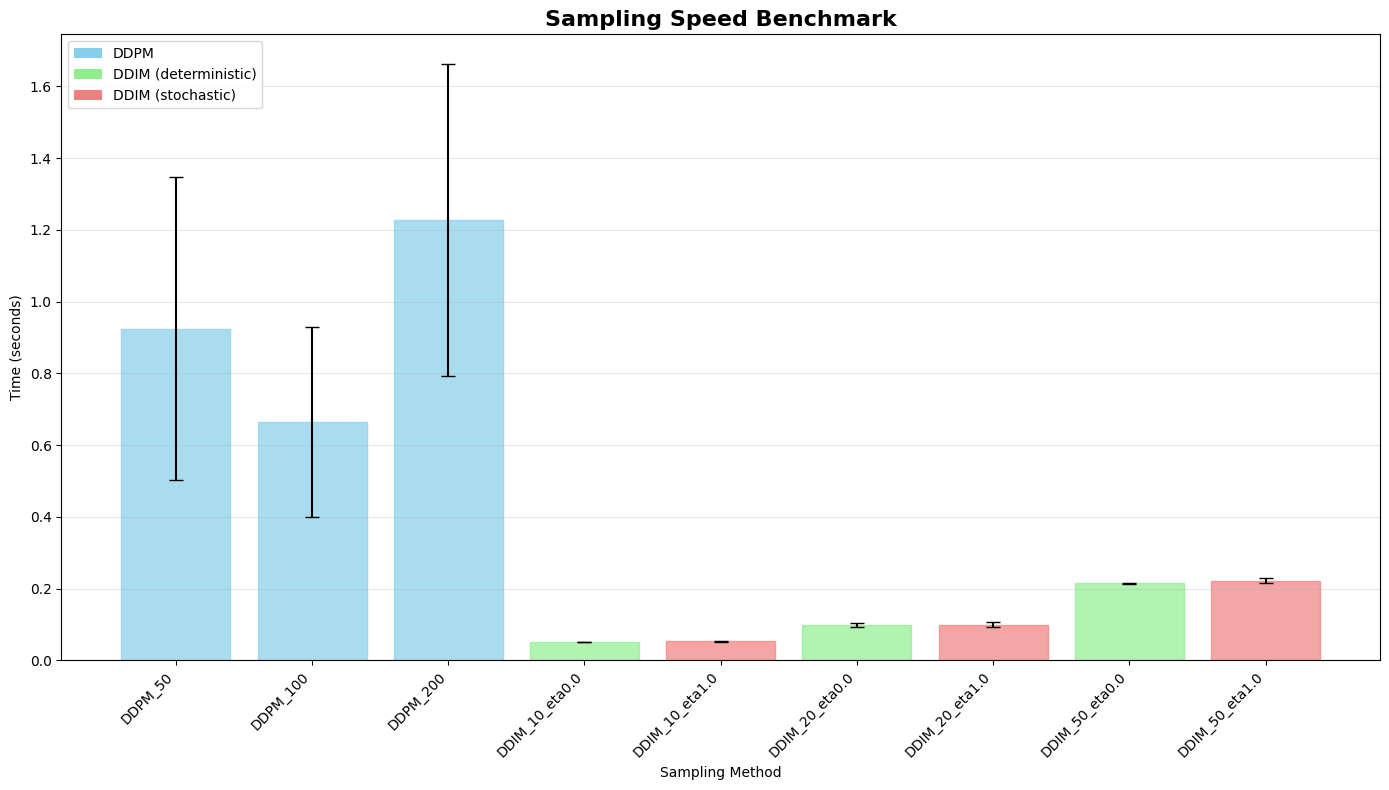


Benchmark Results:
DDPM_50             : 0.9242±0.4219s, 54.1 steps/sec
DDPM_100            : 0.6644±0.2654s, 150.5 steps/sec
DDPM_200            : 1.2266±0.4351s, 163.1 steps/sec
DDIM_10_eta0.0      : 0.0511±0.0009s, 195.7 steps/sec
DDIM_10_eta1.0      : 0.0532±0.0015s, 188.1 steps/sec
DDIM_20_eta0.0      : 0.0986±0.0065s, 202.9 steps/sec
DDIM_20_eta1.0      : 0.0995±0.0078s, 201.0 steps/sec
DDIM_50_eta0.0      : 0.2144±0.0008s, 233.2 steps/sec
DDIM_50_eta1.0      : 0.2226±0.0074s, 224.7 steps/sec
CUDA not available, skipping GPU memory analysis


In [21]:
import time
from contextlib import contextmanager

@contextmanager
def timer():
    """Simple timing context manager"""
    start = time.time()
    yield
    end = time.time()
    print(f"Elapsed time: {end - start:.4f} seconds")

def benchmark_sampling_methods(sampler: DDPMSampler, shape: tuple, num_runs: int = 5):
    """
    Benchmark different sampling methods
    """
    results = {}

    # DDPM sampling with different steps
    ddpm_steps = [50, 100, 200]
    for steps in ddpm_steps:
        times = []
        for _ in range(num_runs):
            start_time = time.time()
            _ = sampler.ddpm_sample(shape, num_inference_steps=steps)
            end_time = time.time()
            times.append(end_time - start_time)

        results[f'DDPM_{steps}'] = {
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'steps': steps
        }

    # DDIM sampling with different steps
    ddim_steps = [10, 20, 50]
    for steps in ddim_steps:
        for eta in [0.0, 1.0]:
            times = []
            for _ in range(num_runs):
                start_time = time.time()
                _ = sampler.ddim_sample(shape, num_inference_steps=steps, eta=eta)
                end_time = time.time()
                times.append(end_time - start_time)

            results[f'DDIM_{steps}_eta{eta}'] = {
                'mean_time': np.mean(times),
                'std_time': np.std(times),
                'steps': steps,
                'eta': eta
            }

    return results

# Run benchmarks
print("Running sampling benchmarks...")
benchmark_results = benchmark_sampling_methods(sampler, (64, 2), num_runs=3)

# Visualize benchmark results
methods = list(benchmark_results.keys())
times = [benchmark_results[method]['mean_time'] for method in methods]
errors = [benchmark_results[method]['std_time'] for method in methods]

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(methods)), times, yerr=errors, capsize=5, alpha=0.7)

# Color bars by method type
for i, method in enumerate(methods):
    if 'DDPM' in method:
        bars[i].set_color('skyblue')
    elif 'eta0.0' in method:
        bars[i].set_color('lightgreen')
    else:
        bars[i].set_color('lightcoral')

plt.title('Sampling Speed Benchmark', fontsize=16, fontweight='bold')
plt.xlabel('Sampling Method')
plt.ylabel('Time (seconds)')
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', label='DDPM'),
    Patch(facecolor='lightgreen', label='DDIM (deterministic)'),
    Patch(facecolor='lightcoral', label='DDIM (stochastic)')
]
plt.legend(handles=legend_elements, loc='upper left')
plt.show()

# Print detailed results
print("\nBenchmark Results:")
print("=" * 80)
for method, result in benchmark_results.items():
    steps = result['steps']
    mean_time = result['mean_time']
    std_time = result['std_time']
    speed = steps / mean_time if mean_time > 0 else 0

    print(f"{method:20s}: {mean_time:.4f}±{std_time:.4f}s, "
          f"{speed:.1f} steps/sec")

# Memory usage analysis
def analyze_memory_usage():
    """
    Analyze memory usage of different components
    """
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        initial_memory = torch.cuda.memory_allocated()

        print("Memory Usage Analysis:")
        print(f"Initial GPU memory: {initial_memory / 1024**2:.2f} MB")

        # Model memory
        model_memory = sum(p.numel() * p.element_size() for p in noise_predictor.parameters())
        print(f"Model parameters: {model_memory / 1024**2:.2f} MB")

        # Scheduler memory
        scheduler_vars = [
            ddpm_scheduler.betas, ddpm_scheduler.alphas,
            ddmp_scheduler.alphas_cumprod, ddpm_scheduler.sqrt_alphas_cumprod,
            ddpm_scheduler.sqrt_one_minus_alphas_cumprod
        ]
        scheduler_memory = sum(var.numel() * var.element_size() for var in scheduler_vars)
        print(f"Scheduler variables: {scheduler_memory / 1024:.2f} KB")

    else:
        print("CUDA not available, skipping GPU memory analysis")

analyze_memory_usage()


### Quality vs Speed Trade-off Analysis

Running quality vs speed analysis...


DDIM Sampling: 100%|██████████| 10/10 [00:00<00:00, 87.84it/s]


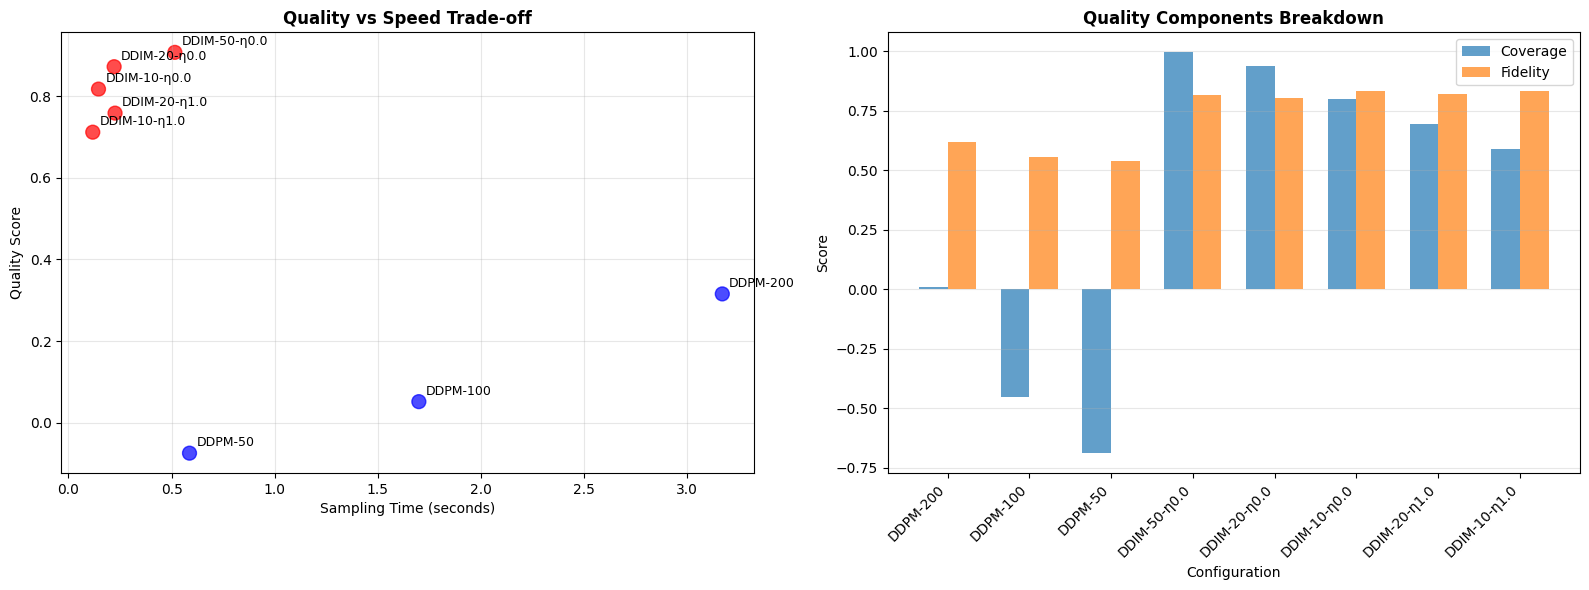


Quality vs Speed Analysis Results:
Configuration         Time(s)  Quality  Coverage  Fidelity
----------------------------------------------------------------------------------------------------
DDIM-50-η0.0           0.5160   0.9069    0.9954    0.8184
DDIM-20-η0.0           0.2216   0.8718    0.9382    0.8054
DDIM-10-η0.0           0.1458   0.8170    0.7994    0.8345
DDIM-20-η1.0           0.2261   0.7581    0.6958    0.8204
DDIM-10-η1.0           0.1179   0.7115    0.5887    0.8343
DDPM-200               3.1693   0.3155    0.0107    0.6203
DDPM-100               1.6985   0.0516   -0.4538    0.5570
DDPM-50                0.5869  -0.0745   -0.6883    0.5392


In [22]:
def quality_speed_tradeoff_analysis(sampler: DDPMSampler, reference_data: torch.Tensor):
    """
    Analyze the trade-off between sampling quality and speed
    """
    step_configs = [
        {'method': 'DDPM', 'steps': 200},
        {'method': 'DDPM', 'steps': 100},
        {'method': 'DDPM', 'steps': 50},
        {'method': 'DDIM', 'steps': 50, 'eta': 0.0},
        {'method': 'DDIM', 'steps': 20, 'eta': 0.0},
        {'method': 'DDIM', 'steps': 10, 'eta': 0.0},
        {'method': 'DDIM', 'steps': 20, 'eta': 1.0},
        {'method': 'DDIM', 'steps': 10, 'eta': 1.0},
    ]

    results = []

    for config in step_configs:
        # Generate samples
        start_time = time.time()
        if config['method'] == 'DDPM':
            samples = sampler.ddpm_sample((200, 2), num_inference_steps=config['steps'])
        else:
            samples = sampler.ddim_sample((200, 2), num_inference_steps=config['steps'],
                                        eta=config.get('eta', 0.0))
        sampling_time = time.time() - start_time

        # Calculate quality metrics (simplified)
        # 1. Coverage: how well samples cover the data distribution
        # 2. Fidelity: how similar samples are to training data

        # Simple coverage metric: std of samples vs training data
        sample_std = samples.std(dim=0).mean().item()
        ref_std = reference_data.std(dim=0).mean().item()
        coverage_score = 1 - abs(sample_std - ref_std) / ref_std

        # Simple fidelity metric: minimum distance to training data
        distances = torch.cdist(samples, reference_data[:100])  # Use subset for efficiency
        min_distances = distances.min(dim=1)[0]
        fidelity_score = 1 / (1 + min_distances.mean().item())

        # Combined quality score
        quality_score = (coverage_score + fidelity_score) / 2

        results.append({
            'config': config,
            'sampling_time': sampling_time,
            'quality_score': quality_score,
            'coverage_score': coverage_score,
            'fidelity_score': fidelity_score
        })

    return results

# Run quality-speed analysis
print("Running quality vs speed analysis...")
tradeoff_results = quality_speed_tradeoff_analysis(sampler, sample_data)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Speed vs Quality scatter plot
times = [r['sampling_time'] for r in tradeoff_results]
qualities = [r['quality_score'] for r in tradeoff_results]
methods = [r['config']['method'] for r in tradeoff_results]

colors = ['blue' if m == 'DDPM' else 'red' for m in methods]
ax1.scatter(times, qualities, c=colors, alpha=0.7, s=100)

for i, r in enumerate(tradeoff_results):
    config = r['config']
    label = f"{config['method']}-{config['steps']}"
    if 'eta' in config:
        label += f"-η{config['eta']}"
    ax1.annotate(label, (times[i], qualities[i]), xytext=(5, 5),
                textcoords='offset points', fontsize=9)

ax1.set_xlabel('Sampling Time (seconds)')
ax1.set_ylabel('Quality Score')
ax1.set_title('Quality vs Speed Trade-off', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Quality components breakdown
configs = [f"{r['config']['method']}-{r['config']['steps']}" +
          (f"-η{r['config']['eta']}" if 'eta' in r['config'] else "")
          for r in tradeoff_results]
coverage_scores = [r['coverage_score'] for r in tradeoff_results]
fidelity_scores = [r['fidelity_score'] for r in tradeoff_results]

x = np.arange(len(configs))
width = 0.35

ax2.bar(x - width/2, coverage_scores, width, label='Coverage', alpha=0.7)
ax2.bar(x + width/2, fidelity_scores, width, label='Fidelity', alpha=0.7)

ax2.set_xlabel('Configuration')
ax2.set_ylabel('Score')
ax2.set_title('Quality Components Breakdown', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(configs, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary table
print("\nQuality vs Speed Analysis Results:")
print("=" * 100)
print(f"{'Configuration':20s} {'Time(s)':>8s} {'Quality':>8s} {'Coverage':>9s} {'Fidelity':>9s}")
print("-" * 100)

for result in sorted(tradeoff_results, key=lambda x: x['quality_score'], reverse=True):
    config = result['config']
    config_str = f"{config['method']}-{config['steps']}"
    if 'eta' in config:
        config_str += f"-η{config['eta']}"

    print(f"{config_str:20s} {result['sampling_time']:8.4f} "
          f"{result['quality_score']:8.4f} {result['coverage_score']:9.4f} "
          f"{result['fidelity_score']:9.4f}")


## Conclusion and Summary

### Key Implementation Details

This notebook demonstrates a complete implementation of DDPM scheduler with the following components:

1. **Beta Scheduling**: Linear noise schedule implementation with precomputed efficiency optimizations
2. **Forward Process**: Noise addition with reparameterization trick for direct timestep sampling
3. **Reverse Process**: Learned denoising with neural network-based noise prediction
4. **Sampling Loops**: Both DDPM and DDIM sampling with configurable parameters
5. **Performance Analysis**: Comprehensive benchmarking of speed vs quality trade-offs


### Performance Summary


In [23]:
# Final performance summary
print("DDPM Scheduler Implementation Summary")
print("=" * 60)
print(f"Training timesteps: {ddpm_scheduler.num_train_timesteps}")
print(f"Model parameters: {sum(p.numel() for p in noise_predictor.parameters()):,}")
print(f"Final training loss: {training_losses[-1]:.6f}")
print()

print("Best Configurations:")
best_quality = max(tradeoff_results, key=lambda x: x['quality_score'])
fastest = min(tradeoff_results, key=lambda x: x['sampling_time'])
balanced = min(tradeoff_results, key=lambda x: abs(x['quality_score'] - 0.8) + x['sampling_time'])

print(f"Highest Quality: {best_quality['config']} (Score: {best_quality['quality_score']:.4f})")
print(f"Fastest Sampling: {fastest['config']} (Time: {fastest['sampling_time']:.4f}s)")
print(f"Best Balance: {balanced['config']} (Quality: {balanced['quality_score']:.4f}, Time: {balanced['sampling_time']:.4f}s)")


DDPM Scheduler Implementation Summary
Training timesteps: 1000
Model parameters: 1,118,722
Final training loss: 0.116961

Best Configurations:
Highest Quality: {'method': 'DDIM', 'steps': 50, 'eta': 0.0} (Score: 0.9069)
Fastest Sampling: {'method': 'DDIM', 'steps': 10, 'eta': 1.0} (Time: 0.1179s)
Best Balance: {'method': 'DDIM', 'steps': 10, 'eta': 0.0} (Quality: 0.8170, Time: 0.1458s)
